In [51]:
import sys
sys.path.append('../')

import pickle

with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_classifier.pkl', 'rb') as f:
    var = pickle.load(f)
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_training_set.pkl', 'rb') as f:
    var_dataset_scaled = pickle.load(f)
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_features_total.pkl', 'rb') as f:
    var_dataset_full = pickle.load(f)
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_features_mira.pkl', 'rb') as f:
    mira_features = pickle.load(f)
var_dataset_full = pd.concat([var_dataset_full, mira_features], axis=0)
var_dataset = var_dataset_full.merge(var_dataset_scaled[['sourceid', 'class', 'prob']], on='sourceid')
var_dataset_full = var_dataset_full[(~var_dataset_full['error'])].reset_index(drop=True)

/data/jls/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [44]:
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/decaps_dataset.pkl', 'rb') as f:
    decaps = pickle.load(f)

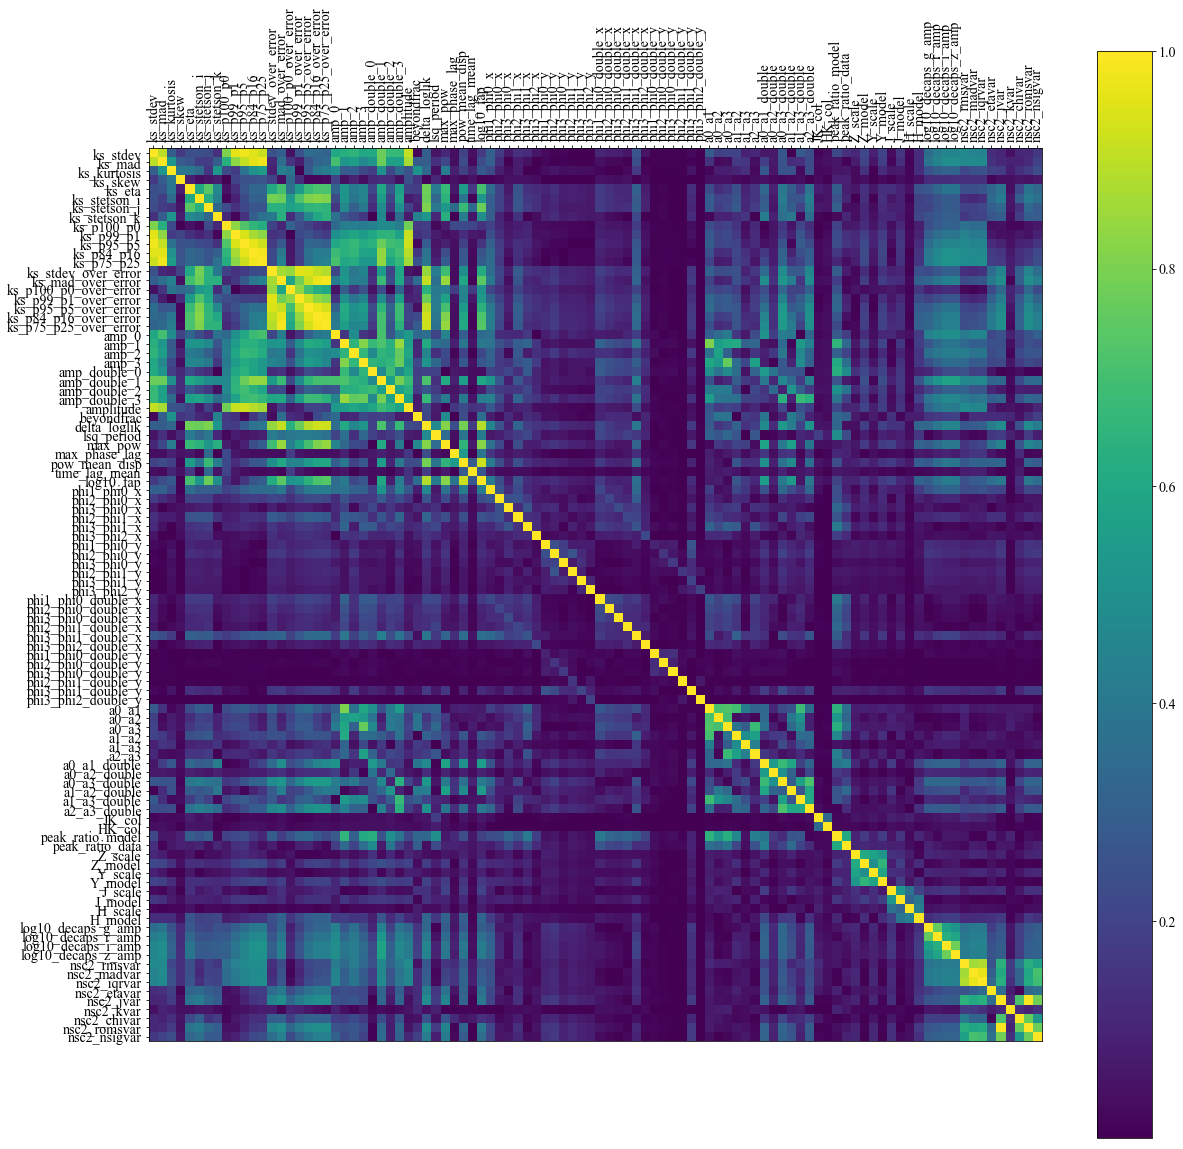

In [45]:
plt.figure(figsize=[20,20])
full_cov = np.cov(var_dataset_scaled[var.data_cols].values.T)
corr = full_cov/np.sqrt(np.diag(full_cov)[:,np.newaxis]*np.diag(full_cov)[np.newaxis,:])
plt.imshow(np.abs(corr))
plt.yticks(np.arange(np.shape(corr)[0]),var.data_cols);
plt.xticks(np.arange(np.shape(corr)[0]),var.data_cols,rotation=90);
plt.gca().xaxis.tick_top()
plt.colorbar()

In [52]:
sorted(var.feature_importance.items(), key=lambda x:x[1])[::-1]

[('log10_fap', 0.21201248),
 ('peak_ratio_model', 0.20173615),
 ('amp_0', 0.09720061),
 ('ks_p84_p16', 0.060831286),
 ('phi3_phi1_double_y', 0.049707074),
 ('ks_stetson_i', 0.047721505),
 ('a0_a1', 0.03893999),
 ('lsq_period', 0.03818293),
 ('amp_double_3', 0.025200257),
 ('ks_p95_p5', 0.019487334),
 ('amp_double_1', 0.014663993),
 ('ks_p75_p25', 0.014500767),
 ('a1_a3_double', 0.01438373),
 ('pow_mean_disp', 0.01434347),
 ('ks_mad', 0.0068178372),
 ('amp_1', 0.006145585),
 ('JK_col', 0.0052448497),
 ('phi1_phi0_y', 0.005195508),
 ('a0_a3_double', 0.004937505),
 ('a0_a1_double', 0.0049275854),
 ('amp_double_0', 0.004414073),
 ('Z_model', 0.0039759222),
 ('phi1_phi0_x', 0.003964332),
 ('J_model', 0.0033828302),
 ('delta_loglik', 0.0031721091),
 ('ks_mad_over_error', 0.0031204957),
 ('amp_3', 0.0031024383),
 ('a0_a2', 0.0029051572),
 ('max_pow', 0.0028419062),
 ('Y_model', 0.0027649691),
 ('phi2_phi0_y', 0.002746189),
 ('a0_a3', 0.0026825047),
 ('amp_2', 0.0023249234),
 ('Y_scale', 0.002

In [7]:
from sklearn.preprocessing import scale
def class_feature_importance(X, Y, feature_importances, keys):
    N, M = X.shape
    X = scale(X)

    out = {}
    for c in set(Y):
        out[c] = pd.DataFrame(dict(
            zip(keys, np.array([np.mean(X[Y==c, :], axis=0)*feature_importances]).T)
        ))
        out[c]['var_class']=str(c)
        out[c]['var_class']=out[c]['var_class'].astype(str)
    out['All']=pd.DataFrame(dict(zip(keys, np.array([feature_importances]).T)))
    out['All']['var_class']='All'
    return out

Y = var_dataset_scaled['var_class']
X = np.vstack([var_dataset_scaled[v[0]] for v in sorted(var.feature_importance.items(), key=lambda x:x[1])[::-1]]).T
fi = np.array([v[1] for v in sorted(var.feature_importance.items(), key=lambda x:x[1])[::-1]])
keys = [v[0] for v in sorted(var.feature_importance.items(), key=lambda x:x[1])[::-1]]
cfi = class_feature_importance(X, Y, fi, keys)
cfi=pd.concat([cfi[c] for c in cfi],axis=0)

cfi=cfi.set_index('var_class').T
# plt.barh(range(len(cfi['CEP'])), importances[indices], color='b', align='center')
# plt.yticks(range(len(cfi['CEP'])), [features[i] for i in indices])

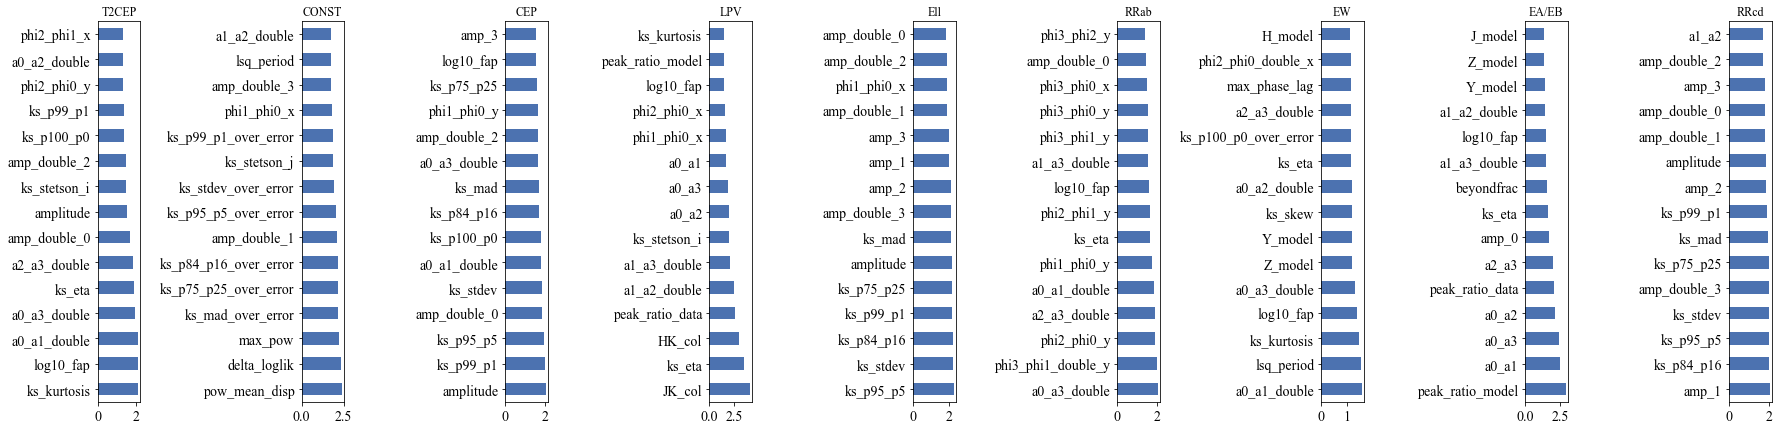

In [8]:
f,a=plt.subplots(1,9,figsize=[30.,7.])
plt.subplots_adjust(wspace=3.8)
for ii,kk in enumerate(['T2CEP','CONST','CEP','LPV','Ell','RRab','EW','EA/EB','RRcd']):
    plt.sca(a[ii])
    np.abs(cfi[kk]/cfi['All']-1).nlargest(15).plot(kind='barh')
    plt.title(kk)

In [3]:
len(var_dataset), len(var_dataset_full)

(142493, 440828)

In [4]:
np.count_nonzero(var_dataset_full['log10_fap']>-10), np.count_nonzero(var_dataset_full['log10_fap_ls']>-10), len(var_dataset_full)

(206945, 248212, 440828)

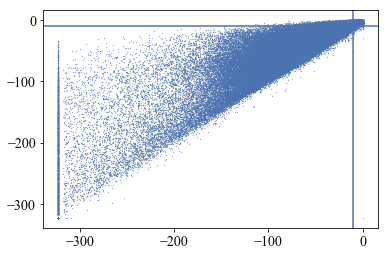

In [809]:
plt.plot(var_dataset_full['log10_fap'], var_dataset_full['log10_fap_ls'], '.',ms=0.5)
plt.axhline(-10.)
plt.axvline(-10.)

In [5]:
fltr = (var_dataset_full['log10_fap']<-10)&(
        ~((var_dataset_full['var_class']=='EA/EB')&~(var_dataset_full['significant_second_minimum'])))

In [200]:
np.count_nonzero((var_dataset_full['var_class']=='MIRA'))

750

[]

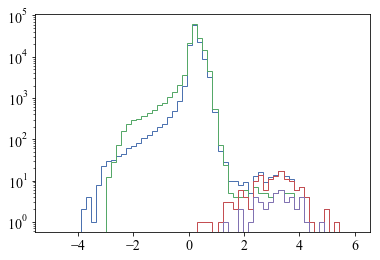

In [835]:
plt.hist(var_dataset_full['JK_col'][fltr],bins=60,range=[-5,6],histtype='step');
plt.hist(var_dataset['JK_col'],bins=60,range=[-5,6],histtype='step');

plt.hist(var_dataset_full['JK_col'][fltr&(var_dataset_full['var_class']=='MIRA')],bins=60,range=[-5,6],histtype='step');
plt.hist(var_dataset['JK_col'][(var_dataset['var_class']=='MIRA')],bins=60,range=[-5,6],histtype='step');

# plt.hist(var_dataset['HK_col'],bins=160,range=[-5,5],histtype='step');
plt.semilogy()

[]

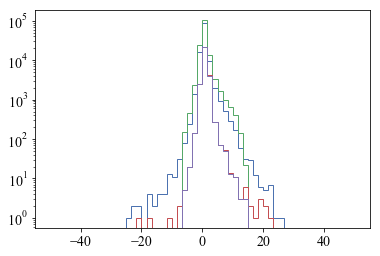

In [154]:
plt.hist(var_dataset_full['ks_skew'][fltr],bins=60,range=[-50,50],histtype='step');
plt.hist(var_dataset['ks_skew'],bins=60,range=[-50,50],histtype='step');

plt.hist(var_dataset_full['ks_skew'][fltr&(var_dataset_full['var_class']=='EA/EB')],bins=60,range=[-50,50],histtype='step');
plt.hist(var_dataset['ks_skew'][(var_dataset['var_class']=='EA/EB')],bins=60,range=[-50,50],histtype='step');

# plt.hist(var_dataset['HK_col'],bins=160,range=[-5,5],histtype='step');
plt.semilogy()

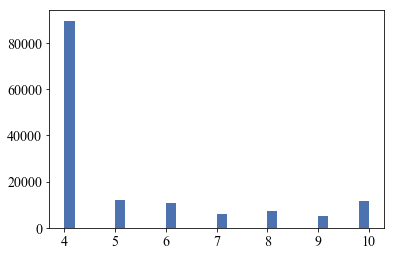

In [836]:
plt.hist(var_dataset['lsq_nterms'],bins=30);

In [53]:
var.cr

{'CEP': {'f1-score': 0.7337278106508875,
  'precision': 0.9073170731707317,
  'recall': 0.6158940397350994,
  'support': 302},
 'CONST': {'f1-score': 0.9977891986562922,
  'precision': 0.9989651604001379,
  'recall': 0.9966160022942357,
  'support': 34870},
 'EA/EB': {'f1-score': 0.9562133303148641,
  'precision': 0.9401966240029679,
  'recall': 0.972785198833103,
  'support': 26052},
 'EW': {'f1-score': 0.9529550353401173,
  'precision': 0.9555175793521148,
  'recall': 0.9504061992250968,
  'support': 40005},
 'Ell': {'f1-score': 0.858712929742495,
  'precision': 0.8745605920444033,
  'recall': 0.8434293870996521,
  'support': 11209},
 'LPV': {'f1-score': 0.9348370927318295,
  'precision': 0.9638242894056848,
  'recall': 0.9075425790754258,
  'support': 411},
 'RRab': {'f1-score': 0.9819896317483018,
  'precision': 0.9831759810282339,
  'recall': 0.980806142034549,
  'support': 22403},
 'RRcd': {'f1-score': 0.9128904201932438,
  'precision': 0.9122754491017964,
  'recall': 0.913506220

In [54]:
from initial_classif.classifier.classifier import ConfusionMatrixDisplay

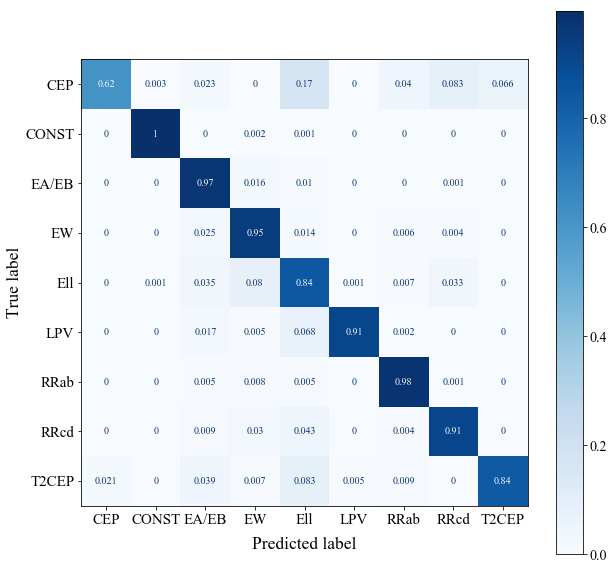

In [55]:
displ = ConfusionMatrixDisplay(confusion_matrix=np.around(var.cm/np.nansum(var.cm,axis=1)[:,np.newaxis], decimals=3),
                                       display_labels=['CEP', 'CONST', 'EA/EB', 'EW', 'Ell', 'LPV', 'RRab', 'RRcd', 'T2CEP'])
disp = displ.plot(include_values=True, cmap=plt.cm.Blues, 
                  ax=None, xticks_rotation='horizontal',
                  values_format=None)

fig = disp.figure_
ax = disp.ax_
im = disp.im_
fig.set_size_inches(10,10)
ax.set_xlabel('Predicted label',family='serif', fontsize=17.5, labelpad=10)
ax.set_ylabel('True label',family='serif', fontsize=17.5, labelpad=2)
#ax.tick_params(labelsize=15)
import matplotlib
ticks_font = matplotlib.font_manager.FontProperties(family='serif',
                                                            style='normal', size=15,
                                                            weight='normal', stretch='normal')
for label in ax.get_xticklabels():
    label.set_fontproperties(ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

In [70]:
sorted(var.feature_importance.items(), key=lambda x:x[1])[::-1]

[('log10_fap', 0.22197498),
 ('peak_ratio_model', 0.20971596),
 ('amp_0', 0.08472359),
 ('ks_p84_p16', 0.065205306),
 ('phi3_phi1_double_y', 0.049926594),
 ('lsq_period', 0.03906049),
 ('a0_a3_double', 0.029256856),
 ('ks_mad', 0.024783924),
 ('amp_double_3', 0.022920039),
 ('ks_stetson_i', 0.020410238),
 ('amp_double_1', 0.020356024),
 ('ks_p95_p5', 0.019177835),
 ('pow_mean_disp', 0.016165547),
 ('a0_a1', 0.012740332),
 ('ks_p75_p25', 0.011823811),
 ('a1_a3_double', 0.0074895415),
 ('delta_loglik', 0.0066314414),
 ('JK_col', 0.0064253453),
 ('log10_decaps_g_amp', 0.0060462942),
 ('amp_1', 0.005009317),
 ('phi1_phi0_y', 0.004222528),
 ('phi1_phi0_x', 0.0037278368),
 ('amp_double_0', 0.0036306237),
 ('J_model', 0.0035880608),
 ('amp_3', 0.0035811714),
 ('a0_a1_double', 0.003344958),
 ('Z_model', 0.0031102733),
 ('ks_mad_over_error', 0.003060323),
 ('max_pow', 0.0029456292),
 ('Y_model', 0.0029401048),
 ('a0_a2', 0.0028627578),
 ('phi2_phi0_y', 0.002584215),
 ('phi3_phi1_double_x', 0.00

In [228]:
from config import configuration
config = configuration()
config.request_password()

 ·············


In [755]:
import sqlutilpy

s = sqlutilpy.local_join('''select v.pmra, v.pmdec, v.parallax, v.pmra_error from t inner join leigh_smith.virac2 as v on v.sourceid=t.sourceid''',
                        't',(var_dataset['sourceid'].values,), ('sourceid',), **config.wsdb_kwargs)

In [310]:
from astropy.coordinates import SkyCoord
import astropy.units as u
sk = SkyCoord(ra=var_dataset['ra'].values*u.deg, dec=var_dataset['dec'].values*u.deg,
              pm_ra_cosdec=s['pmra']*u.mas/u.yr,pm_dec=s['pmdec']*u.mas/u.yr,frame='icrs')
pml = sk.transform_to('galactic').pm_l_cosb.value
pmb = sk.transform_to('galactic').pm_b.value

In [425]:
ecoeff = 0.5

def ew(pp,k,j):
    K = -5.95*np.log10(pp)
    J = -0.04-6.87*np.log10(pp)
    return np.power(10.,0.2*((k-K) - ecoeff*((j-J)-(k-K)))-2)

def rr(pp,k,j,Z=0.02):
    K = -0.6365-2.347*np.log10(pp)+0.1747*np.log10(Z)
    J = -0.2361-1.83*np.log10(pp)+0.1886*np.log10(Z)

    return np.power(10.,0.2*((k-K) - ecoeff*((j-J)-(k-K)))-2)

In [391]:
def betw(x,l,u):
    return (x>l)&(x<u)

In [430]:
from plotting_general import running_median

In [698]:
def dist_from_pm(x):
    min_pm = -2.2
    max_pm = min_pm-4.5
    y = np.zeros_like(x)
    y[x>=min_pm]=1.
    y[x<=max_pm]=8.18
    y[y==0.]=(np.arctanh((x-min_pm)/((max_pm-min_pm)*.5)-1.)*1.1+3.)[y==0.]
    return np.power(10.,-.18*x-.25)
#     return 2*8.18-(1+np.tanh((x+6.379)/3.))*8.18
    return y

538


/data/jls/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in arctanh
  import sys


Text(0.5, 0, 'M_{Ks}')

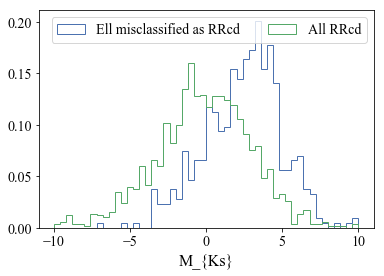

In [769]:
fltr = (var_dataset['var_class']=='Ell')&(var_dataset['class']=='RRcd')&(s['pmra_error']<0.5)
print(np.count_nonzero(fltr))
plt.hist((var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100)
         -0.5*(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col']))[fltr],
           bins=50,normed=True,range=[-10.,10.],histtype='step',label='Ell misclassified as RRcd');

fltr = ((var_dataset['var_class']=='RRc')|(var_dataset['var_class']=='RRd'))&(s['pmra_error']<0.5)
plt.hist((var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100)
         -0.5*(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col']))[fltr],
           bins=50,normed=True,range=[-10.,10.],histtype='step',label='All RRcd');
plt.legend(ncol=2)
plt.xlabel('M_{Ks}')



# fltr = (var_dataset['var_class']=='T2CEP')
# plt.hist((var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100)
#          -0.5*(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col']))[fltr],
#            bins=50,normed=True,range=[-10.,10.],histtype='step',label='All RRcd');

# fltr = (var_dataset['var_class']=='RRc')
# plt.hist((var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100))[fltr],
#            bins=50,normed=True,range=[-15.,25.],histtype='step');

# fltr = (var_dataset['var_class']=='Ell')
# plt.hist((var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100))[fltr],
#            bins=50,normed=True,range=[-15.,25.],histtype='step');

# fltr = (var_dataset['var_class']=='Ell')
# plt.hist((var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100))[fltr],
#            bins=50,normed=True,range=[-15.,25.],histtype='step');
# fltr = (var_dataset['var_class']=='CEP')&(var_dataset['class']=='Ell')
# plt.hist((var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100))[fltr],
#            bins=50,normed=True,range=[-15.,25.],histtype='step');

/data/jls/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in arctanh
  import sys


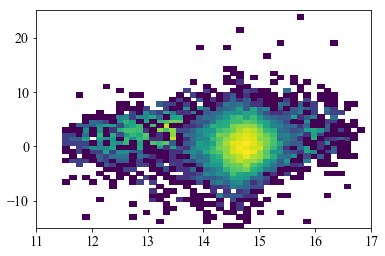

In [701]:


fltr = (var_dataset['var_class']=='Ell')&(var_dataset['JK_col']<0.4)
plt.hist2d(var_dataset['ks_b_ivw_mean_mag'][fltr],
           (var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100))[fltr],
           bins=50,normed=True,range=[[11.,17.],[-15.,25.]],norm=LogNorm());

fltr = (var_dataset['var_class']=='RRc')
plt.hist2d(var_dataset['ks_b_ivw_mean_mag'][fltr],
           (var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100))[fltr],
           bins=50,normed=True,range=[[11.,17.],[-15.,25.]],norm=LogNorm());


# fltr = (var_dataset['var_class']=='Ell')&(var_dataset['class']=='RRcd')
# plt.hist2d(var_dataset['ks_b_ivw_mean_mag'][fltr],
#             pml[fltr],bins=50,normed=True,range=[[11.,17.],[-15.,5.]],norm=LogNorm());

# fltr = (var_dataset['var_class']=='RRc')&(betw(dist_from_pm(pml),1.,7.))
# plt.hist((var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100))[fltr],bins=50,histtype='step',normed=True);
# fltr = (var_dataset['var_class']=='EW')&(betw(dist_from_pm(pml),1.,99.))
# plt.hist((var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100))[fltr],bins=50,histtype='step',normed=True);

# fltr = (var_dataset['var_class']=='CEP')&(betw(dist_from_pm(pml),1.,99.))
# plt.hist((var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100))[fltr],bins=50,histtype='step',normed=True);

In [ ]:
MK = K - 5 log10(dist*100)

10**0.2MK = (10**0.2K)/(dist*100)

In [663]:
np.count_nonzero((var_dataset['var_class']=='RRc'))

7319

/data/jls/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in arctanh
  import sys


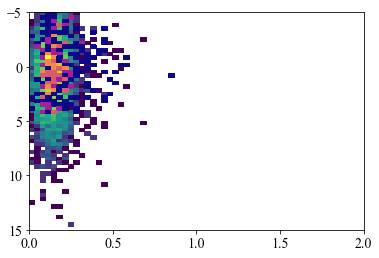

In [665]:
fltr = (var_dataset['var_class']=='RRc')&(betw(dist_from_pm(pml),0.,80.))
plt.hist2d(var_dataset['JK_col'][fltr],
           (var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100))[fltr],bins=60,
          range=[[0.,2.],[-5,15]],norm=LogNorm());
fltr = (var_dataset['var_class']=='RRc')&(var_dataset['class']=='Ell')&(betw(dist_from_pm(pml),1.,80.))
plt.hist2d(var_dataset['JK_col'][fltr],
           (var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100))[fltr],bins=60,
          range=[[0.,2.],[-5,15]],norm=LogNorm(),cmap=plt.cm.plasma);
plt.gca().invert_yaxis()

In [ ]:
d ~ mu_l

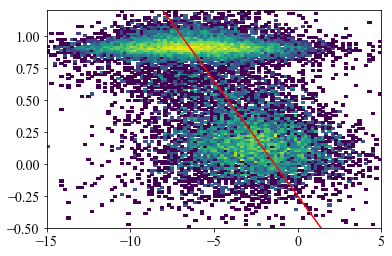

In [773]:
dist_ew = ew(var_dataset['lsq_period'], var_dataset['ks_b_ivw_mean_mag'], var_dataset['j_b_ivw_mean_mag'])
plt.hist2d(pml[(var_dataset['var_class']=='EW')&betw(var_dataset['l'],270,360)&(s['pmra_error']<1.5)],
           np.log10(dist_ew[(var_dataset['var_class']=='EW')&betw(var_dataset['l'],270,360)&(s['pmra_error']<1.5)]),
           range=[[-15,5],[-.5,1.2]],bins=100,
          norm=LogNorm());
# plt.xlim(0.,10.)
# plt.ylim(-15,5)

dist_rr = rr(var_dataset['lsq_period'], var_dataset['ks_b_ivw_mean_mag'], var_dataset['j_b_ivw_mean_mag'])
plt.hist2d(
           pml[(var_dataset['var_class']=='RRab')&betw(var_dataset['l'],270,360)&(s['pmra_error']<1.5)],
    np.log10(dist_rr[(var_dataset['var_class']=='RRab')&betw(var_dataset['l'],270,360)&(s['pmra_error']<1.5)]),
    range=[[-15,5],[-.5,1.2]],bins=100,
          norm=LogNorm());

xx = np.linspace(-15,5)
plt.plot(xx, -.18*xx-.25, color='r')
# plt.xlim(0.,15.)
# plt.ylim(-15,5)
# plt.axhline(-6.879)
# plt.axvline(8.18)

# dist = np.concatenate([dist_ew[(var_dataset['class']=='EW')&betw(var_dataset['l'],0,360)], 
#                        dist_rr[(var_dataset['class']=='RRab')&betw(var_dataset['l'],0,360)]])
# pm_l_ = np.concatenate([pml[(var_dataset['class']=='EW')&betw(var_dataset['l'],0,360)], 
#                        pml[(var_dataset['class']=='RRab')&betw(var_dataset['l'],0,360)]])

# rrr = running_median(dist, pm_l_,nbins=30)
# plt.plot(rrr[0], rrr[1], color='k', lw=10);
# xx = np.linspace(0.,15.)
# plt.plot(xx, -2.2-4.5*.5*(np.tanh((xx-3.)/1.1)+1.),color='r')
# plt.plot(xx, -xx*0.7,color='gold')

# yy = np.linspace(-15,5)
# plt.plot(2*8.18-(1+np.tanh((yy+6.379)/3.))*8.18,yy,color='red',lw=5)

In [776]:
from multiprocessing import Pool
def f(x):
    print(x[0],x[1])
with Pool(4) as p:
    p.map(f, zip(np.array([1,2,3,4,5]),np.array([1,2,3,4,5])*2))

1 2
3 6
2 4
4 8
5 10


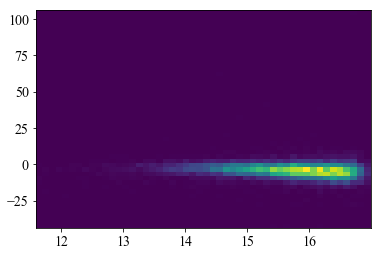

In [357]:
plt.hist2d(var_dataset['ks_b_ivw_mean_mag'][(var_dataset['l']<360.)&(var_dataset['l']>270.)&(var_dataset['class']=='EW')],
        pml[(var_dataset['l']<360.)&(var_dataset['l']>270.)&(var_dataset['class']=='EW')],bins=50);

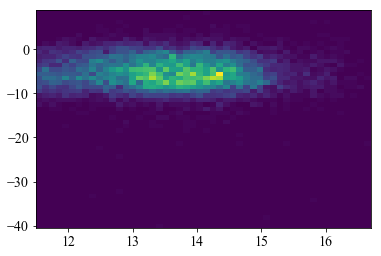

In [347]:
plt.hist2d(var_dataset['ks_b_ivw_mean_mag'][(var_dataset['l']<360.)&(var_dataset['l']>0.)&(var_dataset['class']=='Ell')],
        pml[(var_dataset['l']<360.)&(var_dataset['l']>0.)&(var_dataset['class']=='Ell')],bins=50);

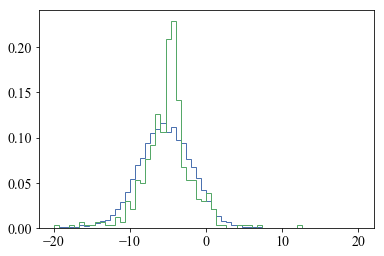

In [338]:
plt.hist(pml[(var_dataset['l']<360.)&(var_dataset['l']>0.)&(var_dataset['class']=='RRcd')],bins=60,range=[-20,20],histtype='step',
        normed=True);
plt.hist(pml[(var_dataset['l']<360.)&(var_dataset['l']>0.)&(var_dataset['class']=='CEP')],bins=60,range=[-20,20],histtype='step',
        normed=True);

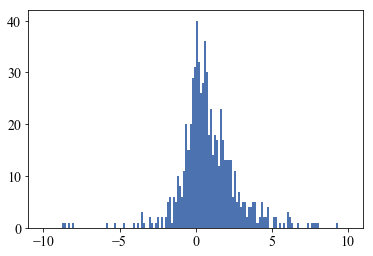

In [276]:
plt.hist(s['parallax'][var_dataset['class']=='LPV'],range=[-10,10],bins=150);

[]

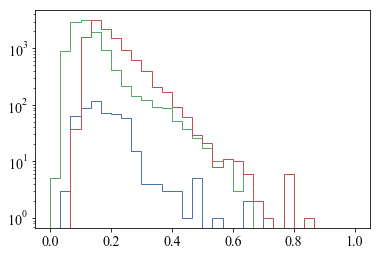

In [292]:
plt.hist(var_dataset['ks_p95_p5'][var_dataset['class']=='CEP'],bins=30,histtype='step',range=[0,1]);
plt.hist(var_dataset['ks_p95_p5'][var_dataset['class']=='Ell'],bins=30,histtype='step',range=[0,1]);
plt.hist(var_dataset['ks_p95_p5'][var_dataset['class']=='RRcd'],bins=30,histtype='step',range=[0,1]);
plt.semilogy()

/data/jls/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/data/jls/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
/data/jls/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/data/jls/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/data/jls/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10
/data/jls/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10


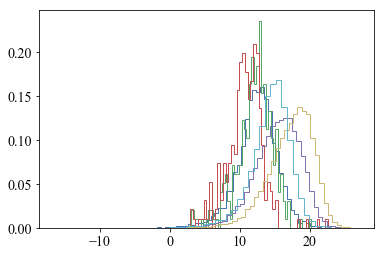

In [269]:
plt.hist((var_dataset['ks_b_ivw_mean_mag']+5.*np.log10(s['parallax'])
          -(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col'])*0.45)[
            var_dataset['class']=='Ell'],
         bins=50,histtype='step',normed=True);
plt.hist((var_dataset['ks_b_ivw_mean_mag']+5.*np.log10(s['parallax'])
          -(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col'])*0.45)[
            var_dataset['class']=='CEP'],
         bins=50,histtype='step',normed=True);
plt.hist((var_dataset['ks_b_ivw_mean_mag']+5.*np.log10(s['parallax'])
          -(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col'])*0.45)[
            var_dataset['class']=='LPV'],
         bins=50,histtype='step',normed=True);
plt.hist((var_dataset['ks_b_ivw_mean_mag']+5.*np.log10(s['parallax'])
          -(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col'])*0.45)[
            var_dataset['class']=='EA/EB'],
         bins=50,histtype='step',normed=True);
plt.hist((var_dataset['ks_b_ivw_mean_mag']+5.*np.log10(s['parallax'])
          -(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col'])*0.45)[
            var_dataset['class']=='EW'],
         bins=50,histtype='step',normed=True);
plt.hist((var_dataset['ks_b_ivw_mean_mag']+5.*np.log10(s['parallax'])
          -(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col'])*0.45)[
            var_dataset['class']=='RRab'],
         bins=50,histtype='step',normed=True);
# # plt.semilogy()

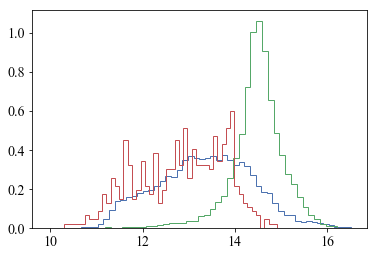

In [294]:
plt.hist((var_dataset['ks_b_ivw_mean_mag']+0.*np.log10(np.sqrt(s['pmra']**2+s['pmdec']**2))
          -(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col'])*0.45)[
            var_dataset['class']=='Ell'],
         bins=50,histtype='step',normed=True);
plt.hist((var_dataset['ks_b_ivw_mean_mag']+0.*np.log10(np.sqrt(s['pmra']**2+s['pmdec']**2))
          -(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col'])*0.45)[
            var_dataset['class']=='RRcd'],
         bins=50,histtype='step',normed=True);
plt.hist((var_dataset['ks_b_ivw_mean_mag']+0.*np.log10(np.sqrt(s['pmra']**2+s['pmdec']**2))
          -(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col'])*0.45)[
            var_dataset['class']=='CEP'],
         bins=50,histtype='step',normed=True);
# plt.semilogy()

/data/jls/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/data/jls/python3.5/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/data/jls/python3.5/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


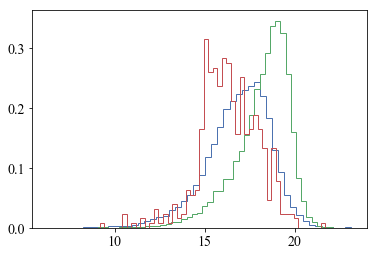

In [293]:
plt.hist((var_dataset['ks_b_ivw_mean_mag']+5.*np.log10(np.sqrt(s['pmra']**2+s['pmdec']**2))
          -(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col'])*0.45)[
            var_dataset['class']=='Ell'],
         bins=50,histtype='step',normed=True);
plt.hist((var_dataset['ks_b_ivw_mean_mag']+5.*np.log10(np.sqrt(s['pmra']**2+s['pmdec']**2))
          -(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col'])*0.45)[
            var_dataset['class']=='RRcd'],
         bins=50,histtype='step',normed=True);
plt.hist((var_dataset['ks_b_ivw_mean_mag']+5.*np.log10(np.sqrt(s['pmra']**2+s['pmdec']**2))
          -(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col'])*0.45)[
            var_dataset['class']=='CEP'],
         bins=50,histtype='step',normed=True);
# plt.semilogy()

[]

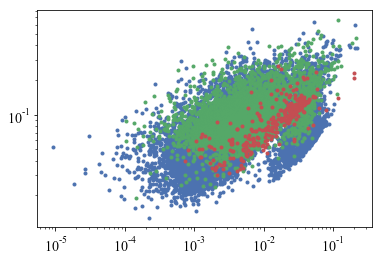

In [224]:
plt.plot(var_dataset['amp_1'][var_dataset['var_class']=='Ell'],
        .5*var_dataset['ks_p95_p5'][var_dataset['var_class']=='Ell'],'.')
plt.plot(var_dataset['amp_1'][var_dataset['var_class']=='RRc'],
        .5*var_dataset['ks_p95_p5'][var_dataset['var_class']=='RRc'],'.')
plt.plot(var_dataset['amp_1'][var_dataset['var_class']=='CEP'],
        .5*var_dataset['ks_p95_p5'][var_dataset['var_class']=='CEP'],'.')
plt.semilogy()
plt.semilogx()

[]

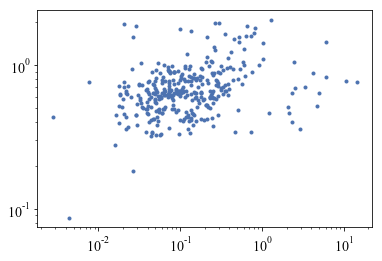

In [194]:
plt.plot(var_dataset['amp_0'][var_dataset['var_class']=='MIRA'],
        var_dataset['ks_p95_p5'][var_dataset['var_class']=='MIRA'],'.')
plt.semilogy()
plt.semilogx()

[]

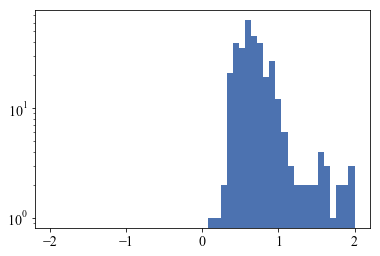

In [195]:
plt.hist(var_dataset['ks_p95_p5'][var_dataset['var_class']=='MIRA'],range=[-2,2],bins=50);
plt.semilogy()

In [15]:
np.unique(var_dataset['var_class'])

array(['CEP', 'CONST', 'DSCT', 'EA/EB', 'EW', 'Ell', 'MIRA', 'OSARG',
       'RRab', 'RRc', 'RRd', 'SRV', 'T2CEP'], dtype=object)

In [14]:
fltr = (var_dataset['var_class']=='LPV')&(var_dataset['log10_fap']<-10)#&(var_dataset['significant_second_minimum'])
np.count_nonzero((var_dataset['class']==var_dataset['var_class'])[fltr]) / np.count_nonzero(fltr)

ZeroDivisionError: division by zero

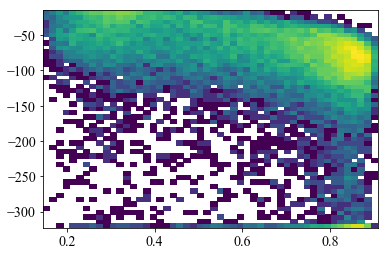

In [131]:
plt.hist2d(var_dataset['prob'][var_dataset['var_class']=='RRab'],
           var_dataset['log10_fap'][var_dataset['var_class']=='RRab'],bins=50,norm=LogNorm());

In [108]:
with open('/local/scratch_2/jls/virac_classifier/binary/edr3/binary_training_set_25.pkl', 'rb') as f:
    binr = pickle.load(f)

/data/jls/python3.5/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


[]

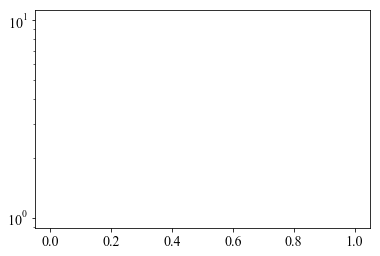

In [126]:

# plt.hist(np.float64(binr.training_set['prob'].values)[
#         (binr.training_set['var_class'].values=='VAR')&(binr.training_set['class'].values=='VAR')
#         ],
#         bins=50);
plt.hist(np.float64(binr.training_set['prob'].values)[
        (binr.training_set['var_class'].values=='VAR')&(binr.training_set['class'].values=='VAR')
        &(binr.training_set['detailed_var_class']=='CONST')],
        bins=50);
plt.semilogy()

In [121]:
np.count_nonzero((binr.training_set['var_class'].values=='VAR')&(binr.training_set['class'].values=='VAR')
                &(binr.training_set['prob']>0.6))/np.count_nonzero((binr.training_set['var_class'].values=='VAR')&(binr.training_set['class'].values=='VAR'))

0.9605704142897007

In [777]:
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_features_total_test.pkl', 'rb') as f:
    var_test = pickle.load(f)

In [800]:
np.count_nonzero(var_test['log10_fap_ls']<-10)

1060

/data/jls/python3.5/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/data/jls/python3.5/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


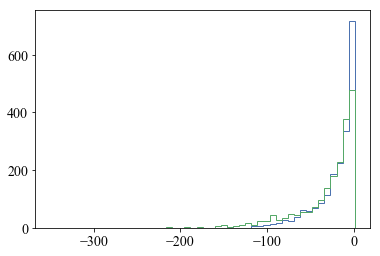

In [798]:
plt.hist(var_test['log10_fap_ls'],bins=50,histtype='step',range=[-350,1])
plt.hist(var_test['log10_fap'],bins=50,histtype='step',range=[-350,1]);

(-50, 0)

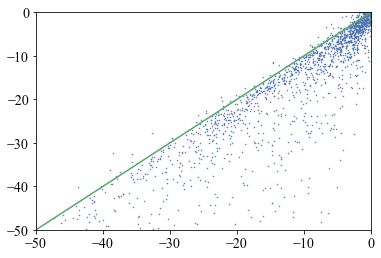

In [789]:
plt.plot(var_test['log10_fap_ls'],var_test['log10_fap'],'.',ms=1)
xx = np.linspace(-200,0)
plt.plot(xx,xx)
plt.ylim(-50,0)
plt.xlim(-50,0)

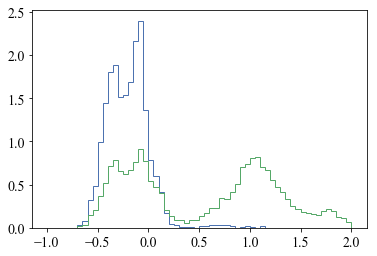

In [823]:
plt.hist(np.log10(var_dataset['cat_period'][(var_dataset['class']=='RRcd')&(var_dataset['var_class']=='Ell')]),bins=60,range=[-1,2],
         histtype='step',normed=True);
plt.hist(np.log10(var_dataset['cat_period'][(var_dataset['var_class']=='Ell')]),bins=60,range=[-1,2],histtype='step',normed=True);

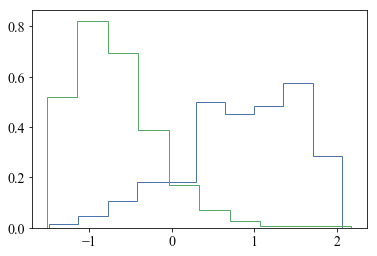

In [253]:
plt.hist(var_dataset_scaled['decaps_g_amp'][(var_dataset_scaled['var_class']=='CEP')&(var_dataset_scaled['class']=='Ell')],histtype='step',density=True)
plt.hist(var_dataset_scaled['decaps_g_amp'][var_dataset_scaled['var_class']=='Ell'],histtype='step',density=True);

In [244]:
np.count_nonzero((var_dataset['var_class']=='CEP')&(var_dataset['class']=='Ell')), np.count_nonzero(var_dataset['var_class']=='CEP')

(42, 301)

In [245]:
np.count_nonzero((var_dataset['var_class']=='CEP')|(var_dataset['var_class']=='Ell'))

11430

In [45]:
for ff in var_dataset.columns:
    print(ff, 
          (np.nanmedian(var_dataset[ff][(var_dataset['var_class']=='CEP')&(var_dataset['class']=='Ell')])
          -np.nanmedian(var_dataset[ff][(var_dataset['var_class']=='Ell')]))/np.diff(np.nanpercentile(var_dataset[ff], [16.,84.]))[0])

HK_col -0.16872662532439708
H_contemp_abs 0.11386730118368694
H_contemp_std 0.005081596428214623
H_model 0.20390257263726225
H_nobs -0.3333333333333333
H_scale 0.19097434742178782
JK_col -0.5012123256887914
J_contemp_abs 0.14140181858543915
J_contemp_std 0.2714275780606172
J_model 0.4313107737786415
J_nobs -0.18181818181818182
J_scale 0.22923791014749353
Y_contemp_abs 3.5304097304227855
Y_contemp_std 1.3430705067207027
Y_model 0.3549804558323893
Y_nobs -0.3333333333333333
Y_scale 0.40963355942691204
Z_contemp_abs 4.105279553799628
Z_contemp_std 1.6384265063025683
Z_model 0.32119009366514034
Z_nobs 0.0
Z_scale 0.3142493601745613
a0_a1 -0.49192759506137873
a0_a1_double 0.0018628589339390487
a0_a2 -0.13323379795248774
a0_a2_double -0.0935952023281476
a0_a3 0.058029344629784436
a0_a3_double -0.35422919401888237
a1_a2 0.05026628613838793
a1_a2_double -0.07721082302902657
a1_a3 0.03490703130019845
a1_a3_double -0.5467301787591302
a2_a3 -0.055581352961390065
a2_a3_double -0.2131029827700932
a

/data/jls/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


error nan
g_amp nan
gaia_sourceid 0.0
h_b_ivw_mean_mag -0.3239067507185304
h_chilt5_ivw_err_mag nan
h_chilt5_ivw_mean_mag nan
h_ivw_err_mag nan
h_ivw_mean_mag nan
h_mad_mag nan
h_mean_mag nan
h_med_mag nan
h_n_ambiguous nan
h_n_chilt5 nan
h_n_detections nan
h_n_observations nan
h_n_phot nan
h_std_mag nan
ivw_mean_contemp_h_ks nan
ivw_mean_contemp_j_ks nan
j_b_ivw_mean_mag -0.35858379126911827
j_chilt5_ivw_err_mag nan
j_chilt5_ivw_mean_mag nan
j_ivw_err_mag nan
j_ivw_mean_mag nan
j_mad_mag nan
j_mean_mag nan
j_med_mag nan
j_n_ambiguous nan
j_n_chilt5 nan
j_n_detections nan
j_n_observations nan
j_n_phot nan
j_std_mag nan
ks_b_ivw_err_mag -0.012293010172478365
ks_b_ivw_mean_mag -0.42564311505474817
ks_chilt5_ivw_err_mag nan
ks_chilt5_ivw_mean_mag nan
ks_eta 0.06322601183808697
ks_ivw_err_mag nan
ks_ivw_mean_mag nan
ks_kurtosis 0.09278001234920168
ks_mad -0.044192597457459584
ks_mad_mag nan
ks_mad_over_error 0.1015731691597591
ks_mean_error -0.052282633168657396
ks_mean_mag nan
ks_med_mag 

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [49]:
var_dataset['ph']

Index(['HK_col', 'H_contemp_abs', 'H_contemp_std', 'H_model', 'H_nobs',
       'H_scale', 'JK_col', 'J_contemp_abs', 'J_contemp_std', 'J_model',
       ...
       'z_mean_mag', 'z_med_mag', 'z_n_ambiguous', 'z_n_chilt5',
       'z_n_detections', 'z_n_observations', 'z_n_phot', 'z_std_mag', 'class',
       'prob'],
      dtype='object', length=235)

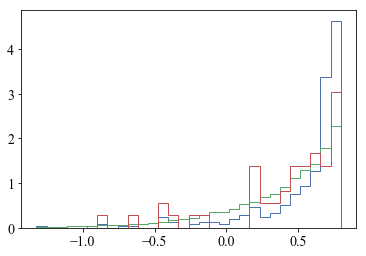

In [55]:
feat = 'phi2_phi1'
n,b,p=plt.hist(np.log10(var_dataset[feat][(var_dataset['var_class']=='CEP')]),histtype='step',bins=30,density=True)
n,b,p=plt.hist(np.log10(var_dataset[feat][(var_dataset['var_class']=='Ell')]),histtype='step',bins=b,density=True)
plt.hist(np.log10(var_dataset[feat][(var_dataset['var_class']=='CEP')&(var_dataset['class']=='Ell')]),histtype='step',bins=b,density=True);

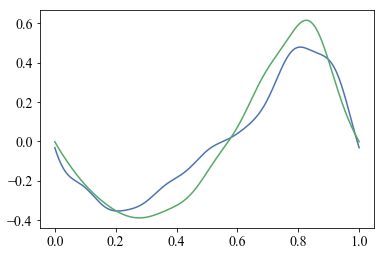

In [43]:
phases = np.linspace(0.,1.,1000)

ampp = np.array([-0.002, 0.367, 0.119, 0.042, 0.008, 0.019, 0.014, 0.011])
phas = np.array([1.382, 1.734, 2.923, -3.029, 2.088, 2.537, 2.960])

plt.plot(phases, ampp[0]+np.sum(ampp[1:,np.newaxis]*np.cos(2.*np.pi*np.arange(1,8)[:,np.newaxis]*phases[np.newaxis,:]+phas[:,np.newaxis]),axis=0))

ampp = np.array([-0.001, 0.460, 0.098, 0.039, 0.021, 0.010, 0.010, 0.003])
phas = np.array([1.311, 2.403, -3.088, -2.344, -1.865, -0.718, 0.999 ])

plt.plot(phases, ampp[0]+np.sum(ampp[1:,np.newaxis]*np.cos(2.*np.pi*np.arange(1,8)[:,np.newaxis]*phases[np.newaxis,:]+phas[:,np.newaxis]),axis=0))

In [71]:
np.count_nonzero((var_dataset['var_class']=='CEP')&(var_dataset['class']=='Ell'))

40

In [69]:
indx=var_dataset.index[(var_dataset['var_class']=='CEP')&(var_dataset['class']=='Ell')]

Int64Index([  1590,   3607,   3847,   4900,  12575,  13175,  13472,  22713,
             26063,  28626,  35343,  37943,  43908,  44094,  68462,  70601,
             81402,  92867,  94866, 106522, 121457, 121710, 123465, 125660,
            126395, 129010, 129035, 130230, 131356, 131407, 131563, 131632,
            132780, 133922, 135111, 137449, 138416, 138747, 139378, 140246,
            140339, 140477, 140679, 140801, 141164, 141203, 141264, 141381,
            141442, 141747, 142158],
           dtype='int64')

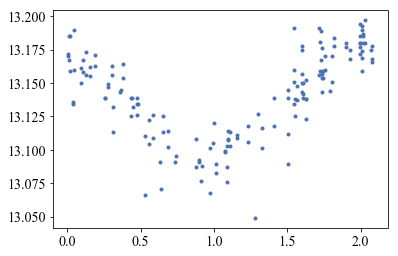

In [118]:
import sqlutilpy
import sys
sys.path.append('../../../../')
from virac_utils import wsdb_kwargs
ii=2
fltr = (var_dataset['var_class']=='CEP')&(var_dataset['class']=='Ell')
sid = var_dataset['sourceid'][fltr].values[ii]
per = var_dataset['lsq_period'][fltr].values[ii]
vv = pd.DataFrame(sqlutilpy.get('''select sourceid, 
                                unnest(mjdobs) as mjdobs,
                                unnest(mag) as mag,
                                unnest(emag) as emag,
                                unnest(filterid) as filterid,
                                unnest(chi) as chi,
                                unnest(ast_res_chisq) as ast_res_chisq,
                                unnest(ambiguous_match) as ambiguous_match  
                                from leigh_smith.virac2_ts_tmolnar_train_zyjhk where sourceid=%i'''%sid, **wsdb_kwargs))
vv = vv[(vv['ambiguous_match']==0)&(vv['ast_res_chisq']<13.)&(vv['filterid']==5)].reset_index(drop=True)
plt.plot(vv['mjdobs']%(per),vv['mag'],'.')
# plt.ylim(np.nanmedian(vv['mag'])-0.1,np.nanmedian(vv['mag'])+0.1)

In [140]:
plt.plot(var_dataset_full['lsq_period'][(var_dataset['var_class']=='Ell')],
        var_dataset_full['pmra'][(var_dataset['var_class']=='Ell')],'.')
plt.plot(var_dataset_full['lsq_period'][(var_dataset['var_class']=='CEP')&(var_dataset['class']=='Ell')],
        var_dataset_full['pmra'][(var_dataset['var_class']=='CEP')&(var_dataset['class']=='Ell')],'.')
# plt.semilogy()
# plt.semilogx()
# plt.ylim(0.02,)

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

In [34]:
import sys
sys.path.append('../../../../')
from virac_utils import cm_decaps, cm_ps1, cm_nsc2

In [77]:
cmatch_N=cm_nsc2(var_dataset[(var_dataset['var_class']=='CEP')&(var_dataset['class']=='Ell')],radeccols=['ra','dec'])
ematch_N=cm_nsc2(var_dataset[(var_dataset['var_class']=='Ell')][-1000:],radeccols=['ra','dec'])
# cmatch=cm_decaps(var_dataset[(var_dataset['var_class']=='CEP')&(var_dataset['class']=='Ell')],radeccols=['ra','dec'])

/data/jls/python3.5/site-packages/sqlutilpy/sqlutil.py:398: UserWarning: Column name ra is repeated in the output, new name ra_1 assigned
  'new name %s assigned') % (_n, curn))
/data/jls/python3.5/site-packages/sqlutilpy/sqlutil.py:398: UserWarning: Column name dec is repeated in the output, new name dec_1 assigned
  'new name %s assigned') % (_n, curn))


In [76]:
np.count_nonzero(cmatch_N['variable10sig']>0), np.count_nonzero(ematch_N['variable10sig']>0)

(34, 9)

In [73]:
np.count_nonzero(cmatch_N['rmag']>0.), len(cmatch_N)

(270, 302)

(0.0, 0.5)

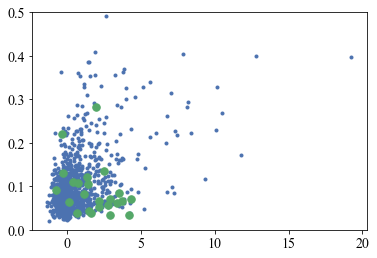

In [115]:
plt.plot(ematch_N['nsigvar'][(ematch_N['rmag']>0)&(ematch_N['ndetr']>5)],
        ematch_N['rmsvar'][(ematch_N['rmag']>0)&(ematch_N['ndetr']>5)],'.');

plt.plot(cmatch_N['nsigvar'][(cmatch_N['rmag']>0)&(cmatch_N['ndetr']>5)],
         cmatch_N['rmsvar'][(cmatch_N['rmag']>0)&(cmatch_N['ndetr']>5)],'.',ms=15);

# plt.xlim(0.,0.3)
plt.ylim(0.,0.5)

In [204]:
ematch=cm_decaps(var_dataset[(var_dataset['var_class']=='EW')][-1000:],radeccols=['ra','dec'])

/data/jls/python3.5/site-packages/sqlutilpy/sqlutil.py:398: UserWarning: Column name ra is repeated in the output, new name ra_1 assigned
  'new name %s assigned') % (_n, curn))
/data/jls/python3.5/site-packages/sqlutilpy/sqlutil.py:398: UserWarning: Column name dec is repeated in the output, new name dec_1 assigned
  'new name %s assigned') % (_n, curn))


In [236]:
%timeit -n 1 -r 1 ematch=cm_decaps(var_dataset[(var_dataset['var_class']=='EW')][-1000:],radeccols=['ra','dec'])

20.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/data/jls/python3.5/site-packages/sqlutilpy/sqlutil.py:398: UserWarning: Column name ra is repeated in the output, new name ra_1 assigned
  'new name %s assigned') % (_n, curn))
/data/jls/python3.5/site-packages/sqlutilpy/sqlutil.py:398: UserWarning: Column name dec is repeated in the output, new name dec_1 assigned
  'new name %s assigned') % (_n, curn))


/data/jls/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/data/jls/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


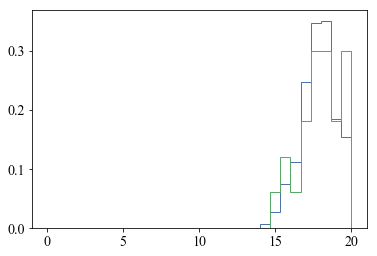

In [227]:
n,b,p=plt.hist(-2.5*np.log10(ematch['mean_g']),histtype='step',density=True,bins=30,range=[0,20])
plt.hist(-2.5*np.log10(cmatch['mean_g']),histtype='step',density=True,bins=b,range=[0,20]);

In [239]:
np.min(cmatch['stdev_z'][cmatch['mean_z']>0])

0.0

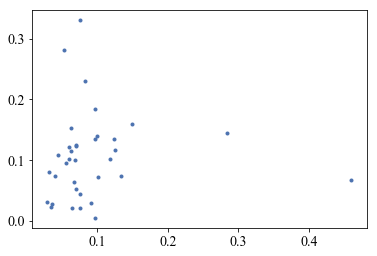

In [216]:
plt.plot(cmatch_N['rrms'],cmatch['stdev_g']/cmatch['mean_g'],'.')

/data/jls/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


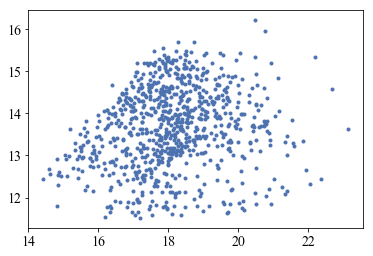

In [198]:
plt.plot(-2.5*np.log10(ematch['mean_g']),var_dataset['ks_b_ivw_mean_mag'][(var_dataset['var_class']=='Ell')][-1000:],'.')

(array([39.73287663, 24.23423681, 23.67064991, 21.4163023 , 18.88016124,
        22.82526956, 13.80787911, 11.83532495, 12.68071087, 10.98993978,
         9.58098155,  8.45379983,  5.35407792,  2.53613995,  2.53614217,
         2.25434662,  0.84538147,  0.84537998,  0.56358666,  0.56358666,
         1.40896911,  0.28179333,  0.28179333,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 array([0.        , 0.00424485, 0.00848971, 0.01273456, 0.01697942,
        0.02122427, 0.02546913, 0.02971398, 0.03395884, 0.03820369,
        0.04244855, 0.0466934 , 0.05093826, 0.05518311, 0.05942797,
        0.06367282, 0.06791767, 0.07216252, 0.07640738, 0.08065224,
        0.08489709, 0.08914194, 0.0933868 , 0.09763166, 0.10187651,
        0.10612136, 0.11036622, 0.11461107, 0.11885593, 0.12310078,
        0.12734564], dtype=float32),
 <a list of 1 Patch objects>)

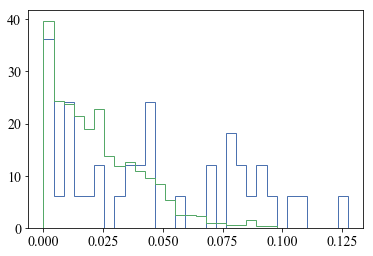

In [240]:
n,b,p=plt.hist(cmatch['stdev_z']/cmatch['mean_z'],histtype='step',bins=30,density=True)
plt.hist(ematch['stdev_z']/ematch['mean_z'],histtype='step',bins=b,density=True)

# n,b,p=plt.hist(cmatch['stdev_i']/cmatch['median_i'],histtype='step',bins=30)
# plt.hist(ematch['stdev_i']/ematch['median_i'],histtype='step',bins=b)

In [64]:
with open('../results_7380776_test.pkl', 'rb') as f:
    leigh_result = pickle.load(f)

In [57]:
with open('/local/scratch_2/jls/virac_classifier/results/edr3/results_7380776_test.pkl', 'rb') as f:
    my_result = pickle.load(f)

In [65]:
leigh_result['sourceid']

AttributeError: 'DataFrame' object has no attribute '_data'

In [66]:
import pandas
print(pandas.__version__)

0.24.0


In [81]:
tt = pd.read_csv('/local/scratch_2/jls/virac_classifier/results/edr3/results_7380776_test.csv.tar.gz')

In [82]:
!ls -lt /local/scratch_2/jls/virac_classifier/results/edr3/results_7380776_test.csv.tar.gz

-rw-r--r-- 1 jls jls 158371 Feb 16 14:58 /local/scratch_2/jls/virac_classifier/results/edr3/results_7380776_test.csv.tar.gz


In [97]:
tt['sourceid'][(tt['class']=='RRab')&(tt['prob']>0.8)]

81    9270237019892
Name: sourceid, dtype: int64

In [102]:
import sys
sys.path.append('../')
from interface_utils.light_curve_loader import lightcurve_loader
ll = lightcurve_loader('/data/jls/virac/')

In [105]:
lc=ll([9270237019892])

In [108]:
np.unique(lc['filterid'])

4
5


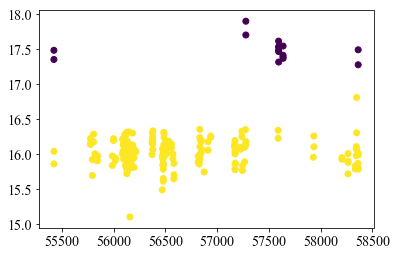

In [109]:
plt.scatter(lc['mjdobs'],lc['mag'],c=lc['filterid'])

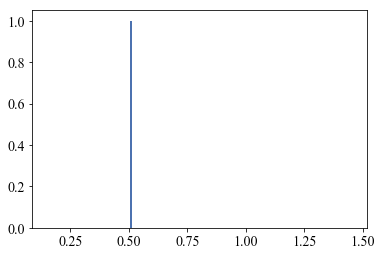

In [96]:
plt.hist(tt['lsq_period'][(tt['class']=='RRab')&(tt['prob']>0.8)],bins=150,range=[0.15,1.45]);
# plt.axvline(1./3.+0.005,color='k')
# plt.axvline(1./3.-0.005,color='k')

# plt.axvline(0.99726/3.+0.005,color='k')
# plt.axvline(0.99726/3.-0.005,color='k')

(2.0, 3.0)

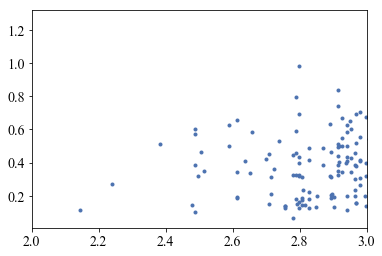

In [92]:
plt.plot(np.log10(tt['lsq_period'][tt['class']!='CONST']),tt['amplitude'][tt['class']!='CONST'],'.');
plt.xlim(2.,3.)